In [87]:
import catboost
import numpy as np
import pandas as pd
from os import walk
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import itertools
import matplotlib.pyplot as plt

In [23]:
def calc_spread_return_sharpe(df: pd.DataFrame, portfolio_size: int = 200, toprank_weight_ratio: float = 2) -> float:
    """
    Args:
        df (pd.DataFrame): predicted results
        portfolio_size (int): # of equities to buy/sell
        toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
    Returns:
        (float): sharpe ratio
    """
    def _calc_spread_return_per_day(df, portfolio_size, toprank_weight_ratio):
        """
        Args:
            df (pd.DataFrame): predicted results
            portfolio_size (int): # of equities to buy/sell
            toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
        Returns:
            (float): spread return
        """
        assert df['Rank'].min() == 0
        assert df['Rank'].max() == len(df['Rank']) - 1
        weights = np.linspace(start=toprank_weight_ratio, stop=1, num=portfolio_size)
        purchase = (df.sort_values(by='Rank')['Target'][:portfolio_size] * weights).sum() / weights.mean()
        short = (df.sort_values(by='Rank', ascending=False)['Target'][:portfolio_size] * weights).sum() / weights.mean()
        return purchase - short

    buf = df.groupby('Date').apply(_calc_spread_return_per_day, portfolio_size, toprank_weight_ratio)
    sharpe_ratio = buf.mean() / buf.std()
    return sharpe_ratio

def prep_prices(price):
    price.fillna(0,inplace=True)
    return price

In [5]:
sample = pd.read_csv("example_test_files/sample_submission.csv")
sample.head()

,Date,SecuritiesCode,Rank
0,2021-12-06,1301,0
1,2021-12-06,1332,1
2,2021-12-06,1333,2
3,2021-12-06,1375,3
4,2021-12-06,1376,4


In [27]:
path = 'train_files'
for dirpath, dirnames, filenames in walk(path):
    for f in filenames:
        print('tr_'+f.split('.')[0])
        globals()['tr_'+f.split('.')[0]] = pd.read_csv(dirpath+'/'+f)
    

tr_financials


C:\Users\79222\AppData\Local\Programs\Python\Python37\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (14,15,16,17,18,19,42,44) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


tr_options


C:\Users\79222\AppData\Local\Programs\Python\Python37\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (7,8,9,10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


tr_secondary_stock_prices
tr_stock_prices
tr_trades


In [30]:
tr_stock_prices.head(2)

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324


## Prices features

### On data as a whole

In [37]:
tr_stock_prices = prep_prices(tr_stock_prices)

feats = ['Open','High','Low','Volume']
X = (tr_stock_prices[feats])
y = tr_stock_prices['Close']
featrures.head(2)

,Date,Open,High,Low,Close,Volume
0,2017-01-04,2734.0,2755.0,2730.0,2742.0,31400
1,2017-01-04,568.0,576.0,563.0,571.0,2798500


In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [42]:
lr = LinearRegression()

In [49]:
lr.fit(X_train,y_train)
lr_pred = lr.predict(X_test)
mean_squared_error(y_test, lr_pred)

1711.6233860656139

In [47]:
cat_reg = catboost.CatBoostRegressor()
cat_reg.fit(X_train,y_train)
cat_pred = cat_reg.predict(X_test)

Learning rate set to 0.14915
0:	learn: 2884.7654897	total: 268ms	remaining: 4m 27s
1:	learn: 2509.1296458	total: 357ms	remaining: 2m 58s
2:	learn: 2192.5930854	total: 446ms	remaining: 2m 28s
3:	learn: 1929.3806823	total: 534ms	remaining: 2m 12s
4:	learn: 1708.2385228	total: 625ms	remaining: 2m 4s
5:	learn: 1525.2549335	total: 718ms	remaining: 1m 58s
6:	learn: 1375.5886605	total: 813ms	remaining: 1m 55s
7:	learn: 1254.8269145	total: 908ms	remaining: 1m 52s
8:	learn: 1157.6217392	total: 999ms	remaining: 1m 50s
9:	learn: 1078.8576693	total: 1.09s	remaining: 1m 47s
10:	learn: 1017.5343147	total: 1.18s	remaining: 1m 46s
11:	learn: 969.9261832	total: 1.28s	remaining: 1m 45s
12:	learn: 932.3644432	total: 1.37s	remaining: 1m 44s
13:	learn: 902.7187054	total: 1.47s	remaining: 1m 43s
14:	learn: 877.1227968	total: 1.57s	remaining: 1m 43s
15:	learn: 858.2604125	total: 1.67s	remaining: 1m 42s
16:	learn: 842.8080651	total: 1.76s	remaining: 1m 41s
17:	learn: 832.1249815	total: 1.85s	remaining: 1m 41s

1711.6233860656139

In [48]:
mean_squared_error(y_test, cat_pred)

2182398.9858976076

# On each Stock separatly

In [50]:
tr_stock_prices = prep_prices(tr_stock_prices)
feats = ['Open','High','Low','Volume']

In [52]:
tr_stock_prices.head(2)

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,0.0,False,0.000730
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,0.0,False,0.012324


In [112]:
lr = LinearRegression()
all_lr_preds = []
all_y_test = []
all_mses = []
for ix in tr_stock_prices['SecuritiesCode'].unique():
    data = tr_stock_prices[tr_stock_prices['SecuritiesCode']==ix]
    X = (data[feats])
    y = data['Close'].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
    lr.fit(X_train,y_train)
    lr_pred = lr.predict(X_test)
    mse = mean_squared_error(y_test, lr_pred)
    
    all_lr_preds.append(lr_pred)
    all_y_test.append(y_test)
    all_mses.append(mse)

In [113]:
sum(all_mses)/len(all_mses) # mean ie macro average mse

1683.7735534798803

In [ ]:
all_lr_preds = (list(itertools.chain.from_iterable(all_lr_preds)))
all_y_test = ((list(itertools.chain.from_iterable(all_y_test))))

In [119]:
mean_squared_error(all_y_test, all_lr_preds) # micro-average mse

1507.9864235382295

In [120]:
# CATBOOST

cat_reg = catboost.CatBoostRegressor(verbose = False)
all_cat_preds = []
all_y_test = []
all_mses_cat = []
for ix in tr_stock_prices['SecuritiesCode'].unique():
    data = tr_stock_prices[tr_stock_prices['SecuritiesCode']==ix]
    X = (data[feats])
    y = data['Close'].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
    cat_reg.fit(X_train,y_train)
    cat_pred = cat_reg.predict(X_test)
    mse = mean_squared_error(y_test, cat_pred)
    
    all_cat_preds.append(cat_pred)
    all_y_test.append(y_test)
    all_mses_cat.append(mse)


In [121]:
sum(all_mses_cat)/len(all_mses_cat) # mean ie macro average mse

622212.8146984581

In [80]:
all_cat_preds = (list(itertools.chain.from_iterable(all_cat_preds)))
all_y_test = ((list(itertools.chain.from_iterable(all_y_test))))

In [81]:
mean_squared_error(all_y_test, all_cat_preds) # micro-average mse

620032.3933677565

In [86]:
tr_stock_prices['SecuritiesCode'].unique()[1040]

6532

In [105]:
data = tr_stock_prices[tr_stock_prices['SecuritiesCode']==6532]
X = data[feats]
y = data['Close'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
cat_reg.fit(X_train,y_train)
cat_pred = cat_reg.predict(X_test)

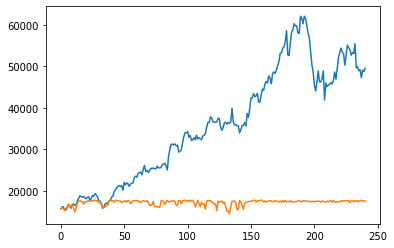

In [106]:
plt.plot(y_test)
plt.plot(cat_pred)